In [1]:
import numpy as np
import torch.nn as nn
import torch
import sys
import os
import ase

from tqdm.notebook import tqdm

from ase.io import read, write
from ase.visualize import view
from ase.db import connect

from torch.utils.data import  RandomSampler
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.optim import Adam
import torch.nn.functional as F

from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

# We specify the CPU as the training/simulating device here.
# If you have machine  with a GPU, you can use the GPU for
# accelerated training/simulation by specifying 
# device = torch.device('cuda')
device = torch.device('cpu')


import pytorch_lightning as pl
from torch_cluster import radius
from e3nn import o3
from torch_scatter import scatter
from torch_geometric.data import DataLoader
import torch
torch.set_num_threads(1)
from pytorch_prototype.full_torch.neighbor_list import ase2data

import nice

In [2]:
import copy
def process_structures(structures, delta = 0.1):   
    """Satisfying librascal desire of having all atoms 
    inside the cell even if structure is not periodic. 
    (changes only non periodic structures)
    """

    result = []
    for structure in structures:
        if True in structure.pbc:
            result.append(copy.deepcopy(structure))
        else:
            current = copy.deepcopy(structure)
            for dim in range(3):
                min_now = np.min( current.positions[:, dim])
                current.positions[:, dim] =  current.positions[:, dim] - min_now + delta
            
            spreads = []
            for dim in range(3):                
                spreads.append(np.max(current.positions[:, dim]) + delta)
            current.cell = spreads
            result.append(current)
    return result

# test pytorch impl of PS and kernel computation

In [3]:
import sys
sys.path.insert(0,'/home/musil/git/librascal/build')
from rascal.representations import SphericalInvariants
from rascal.representations import SphericalExpansion as SphericalExpansion_rascal
from rascal.utils import FPSFilter, load_obj, dump_obj
from rascal.models import Kernel


In [4]:
from pytorch_prototype.full_torch.invariants import PowerSpectrum
from pytorch_prototype.full_torch.models import SGPRModel

In [5]:
frames =  process_structures(read('./structures/methane.extxyz','500:508'))

sps = []
for ff in frames:
    ff.wrap(eps=1e-10)
    sps.extend(ff.get_atomic_numbers())
nsp = len(np.unique(sps))
species = torch.from_numpy(np.unique(sps)).to(dtype=torch.int32)
data_list = [ase2data(ff) for ff in frames]
dataloader = DataLoader(data_list)


In [6]:
rc = 3
gs = 0.3
lmax = 5
nmax = 6
cutoff_smooth_width = 0.5
normalize = True
zeta = 4

In [7]:
weigths = np.ones((len(sps), 1))

## rascal

In [8]:
hypers = dict(
              interaction_cutoff=rc, 
              max_radial=nmax, 
              max_angular=lmax, 
              gaussian_sigma_constant=gs,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=cutoff_smooth_width,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              cutoff_function_type = 'ShiftedCosine',
                soap_type= "PowerSpectrum",
                normalize= normalize,
              )
soap = SphericalInvariants(**hypers)
managers = soap.transform(frames)
PS_ref = torch.from_numpy(managers.get_features(soap))


In [9]:
kk_ref = np.dot(PS_ref, PS_ref.T)
y_ref = np.dot(kk_ref, weigths)

In [10]:
n_sparses = {int(sp):2 for sp in species}
compressor = FPSFilter(soap, n_sparses, act_on='sample per species')
compressor.select(managers)
X_sparse = compressor.filter(managers, n_sparses)
X_train_ref = torch.from_numpy(X_sparse.get_features())

The number of pseudo points selected by central atom species is: {1: 2, 6: 2}
Selecting species: 1
Selecting species: 6


In [11]:
nn = 0
sel = {int(sp):[] for sp in species}
for ii,ff in enumerate(frames):
    sps = ff.get_atomic_numbers()[compressor.selected_ids[ii]]
    for sp in species:
        sel[int(sp)].append([])
    for sp,idx in zip(sps, compressor.selected_ids[ii]):
        sel[sp][-1].append(idx)
sel

{1: [[1], [], [], [], [], [], [4], []], 6: [[0], [], [0], [], [], [], [], []]}

In [12]:
compressor.selected_ids

[[0, 1], [], [0], [], [], [], [4], []]

In [13]:
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [14]:
KNM_ref = kernel(managers, X_sparse, grad=(False, False))
dKNM_ref = kernel(managers, X_sparse, grad=(True, False))

In [15]:
ww = torch.ones((X_train_ref.shape[0]))
y_ref = KNM_ref @ ww.numpy()
dy_ref = dKNM_ref @ ww.numpy()

## test PS pytorch impl

In [16]:
calculator = PowerSpectrum(nmax, lmax, rc, gs, species, normalize=normalize)

In [17]:
X_sp = {int(sp):[] for sp in species}
nn = 0
for data in dataloader:
    PS = calculator(data)
    for ii in range(nn, nn+len(data.n_atoms)):
        for sp in X_sp:
            X_sp[sp].append(PS[sel[sp][ii]])
    nn += len(data.n_atoms)
sp_map = {}
nn = 0
for sp in X_sp:
    X_sp[sp] = torch.cat(X_sp[sp])
    sp_map[sp] = range(nn, nn+X_sp[sp].shape[0])
    nn += X_sp[sp].shape[0]
    
X_train = torch.cat(list(X_sp.values()))

aa = X_train @ X_train.t()
bb = X_train_ref @ X_train_ref.t()
np.allclose(aa.numpy(), bb.numpy())

True

In [18]:
def compute_kernel(data, PS, X_train, sp_map, zeta):
    species = torch.unique(data.z)
    k_mat = torch.zeros((len(data.n_atoms), X_train.shape[0]), dtype=PS.dtype, device=PS.device)
    for sp in species.tolist():
        mask = data.z == sp
        k_partial = torch.pow(PS[mask] @ X_train[sp_map[sp]].t(), zeta)
        scatter(k_partial, data.batch[mask], dim=0, out=k_mat)
    return k_mat

y = []
dy = []
for data in dataloader:
    data.pos.requires_grad_(True)
    PS = calculator(data)
    ww = torch.ones((X_train.shape[0]),dtype=PS.dtype)
    Kmat = compute_kernel(data, PS, X_train, sp_map, zeta)
    yy = torch.matmul(Kmat, ww) 
    dyy = torch.autograd.grad(yy, data.pos, grad_outputs=torch.ones_like(yy), 
                                   create_graph=True, retain_graph=True)[0]
    y.append(yy)
    dy.append(dyy)
y = torch.cat(y).detach()
dy = torch.cat(dy).detach().flatten()

In [19]:
np.allclose(y_ref, y.numpy(), atol=1e-5),np.allclose(dy_ref, dy.numpy(), atol=1e-5)

(True, True)

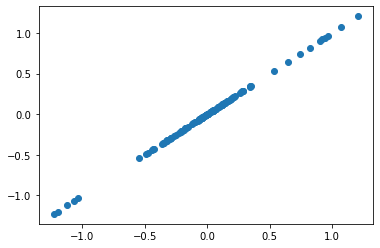

In [21]:
plt.plot(dy_ref, dy.numpy(), 'o')

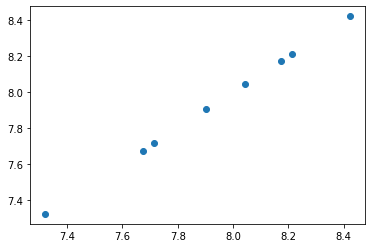

In [22]:
plt.plot(y_ref, y.numpy(), 'o')

## compare computation times

In [67]:
# frames = read('molecular_crystal.json',':')
# frames += read('delta_silicon.xyz','1500:1502')
frames = process_structures(read('./structures/methane.extxyz','0:5000'))

sps = []
for ff in frames:
    ff.wrap(eps=1e-10)
    sps.extend(ff.get_atomic_numbers())
nsp = len(np.unique(sps))
sp_counts = np.bincount(sps)
species = torch.from_numpy(np.unique(sps)).to(dtype=torch.int32)
data_list = [ase2data(ff) for ff in frames]
dataloader = DataLoader(data_list, batch_size=64)


In [68]:
rc = 3
gs = 0.3
lmax = 5
nmax = 6
cutoff_smooth_width = 0.5
normalize = True
zeta = 4

In [69]:
n_sparses = {1:1000, 6:1000}

### get sparse points

In [70]:
hypers = dict(
              interaction_cutoff=rc, 
              max_radial=nmax, 
              max_angular=lmax, 
              gaussian_sigma_constant=gs,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=cutoff_smooth_width,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              cutoff_function_type = 'ShiftedCosine',
                soap_type= "PowerSpectrum",
                normalize= normalize,
              )
soap = SphericalInvariants(**hypers)
managers = soap.transform(frames)

In [71]:

compressor = FPSFilter(soap, n_sparses, act_on='sample per species')
compressor.select(managers)
X_sparse = compressor.filter(managers, n_sparses)
# X_train_ref = torch.from_numpy(X_sparse.get_features())

The number of pseudo points selected by central atom species is: {1: 1000, 6: 1000}
Selecting species: 1
Selecting species: 6


In [86]:
nn = 0
sel = {int(sp):[] for sp in species}
for ii,ff in enumerate(frames):
    sps = ff.get_atomic_numbers()[compressor.selected_ids[ii]]
    for sp in species:
        sel[int(sp)].append([])
    for sp,idx in zip(sps, compressor.selected_ids[ii]):
        sel[sp][-1].append(idx)

### compute rascal

In [73]:
hypers = dict(
              interaction_cutoff=rc, 
              max_radial=nmax, 
              max_angular=lmax, 
              gaussian_sigma_constant=gs,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=cutoff_smooth_width,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              cutoff_function_type = 'ShiftedCosine',
                soap_type= "PowerSpectrum",
                normalize= normalize,
              )
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

ww = np.ones((X_train_ref.shape[0])) / np.sum(list(n_sparses.values()))

In [74]:
def rascal_compute(frame):
    managers = soap.transform(frame)
    KNM_ref = kernel(managers, X_sparse, grad=(False, False))
    dKNM_ref = kernel(managers, X_sparse, grad=(True, False))
    y_ref = KNM_ref @ ww
    dy_ref = dKNM_ref @ ww
    return y_ref, dy_ref

y_ref = []
dy_ref = []
for frame in tqdm(frames):
    yy, dyy = rascal_compute(frame)
    y_ref.extend(yy)
    dy_ref.extend(dyy)
y_ref = np.array(y_ref)
dy_ref = np.array(dy_ref)


  0%|          | 0/5000 [00:00<?, ?it/s]

### torch compute

In [93]:
calculator = PowerSpectrum(nmax, lmax, rc, gs, species, normalize=normalize, smooth_width=cutoff_smooth_width)

In [94]:
X_sp = {int(sp):[] for sp in species}
nn = 0
for data in dataloader:
    PS = calculator(data)
    for ii in range(nn, nn+len(data.n_atoms)):
        for sp in X_sp:
            X_sp[sp].append(PS[sel[sp][ii]])
    nn += len(data.n_atoms)
sp_map = {}
nn = 0
for sp in X_sp:
    X_sp[sp] = torch.cat(X_sp[sp])
    sp_map[sp] = range(nn, nn+X_sp[sp].shape[0])
    nn += X_sp[sp].shape[0]
    
X_train = torch.cat(list(X_sp.values()))

In [95]:
from torch_scatter import scatter
def compute_kernel(data, PS, X_train, sp_map, zeta):
    species = torch.unique(data.z)
    k_mat = torch.zeros((len(data.n_atoms), X_train.shape[0]), dtype=PS.dtype, device=PS.device)
    for sp in species.tolist():
        mask = data.z == sp
        k_partial = torch.pow(PS[mask] @ X_train[sp_map[sp]].t(), zeta)
        scatter(k_partial, data.batch[mask], dim=0, out=k_mat)
    return k_mat

ww = torch.ones((X_train.shape[0]), dtype=X_train.dtype) / np.sum(list(n_sparses.values()))

y = []
dy = []
for data in tqdm(dataloader):
    data.pos.requires_grad_(True)
    PS = calculator(data)
    Kmat = compute_kernel(data, PS, X_train, sp_map, zeta)
    yy = torch.matmul(Kmat, ww) 
    dyy = torch.autograd.grad(yy, data.pos, grad_outputs=torch.ones_like(yy), 
                                   create_graph=False, retain_graph=False)[0]
    y.append(yy)
    dy.append(dyy)
y = torch.cat(y).detach()
dy = torch.cat(dy).detach().flatten()

  0%|          | 0/79 [00:00<?, ?it/s]